In [1]:
# Importando as bibliotecas
from CoolProp.CoolProp import PropsSI, PhaseSI
import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Calcula qualquer ponto informando dicionario com duas variaveis
def calculate_point(point):
    variables = ['T', 'H', 'S', 'Q', 'P']
    input_variables = list(point.keys())
    output_variables = [variable for variable in variables if variable not in input_variables]
    output_values = PropsSI(output_variables, 
                            input_variables[0], 
                            point[input_variables[0]], 
                            input_variables[1], 
                            point[input_variables[1]], 
                            input_values['refrigerant']
    )

    for index, variable in enumerate(output_variables):
        point[variable] = output_values[index]

    return point

In [3]:
# Calcula ciclo baseado nas variaveis de entrada
def calculate_cycle(cycle_inputs):
    t_0 = cycle_inputs['t_external_env']
    
    point_1_saturado = {'Q': 1, 'T': cycle_inputs['t_internal_env'] - cycle_inputs['approach_evaporator']}
    calculate_point(point_1_saturado)

    point_1 = {'P': point_1_saturado['P'], 'T': point_1_saturado['T'] + cycle_inputs['superheating']}
    calculate_point(point_1)

    point_3_saturado = {'Q': 0, 'T': cycle_inputs['t_external_env'] + cycle_inputs['approach_condenser']}
    calculate_point(point_3_saturado)

    point_3 = {'P': point_3_saturado['P'], 'T': point_3_saturado['T'] - cycle_inputs['subcooling']}
    calculate_point(point_3)

    point_2_isen = {'S': point_1['S'], 'P': point_3['P']}
    calculate_point(point_2_isen)

    point_2 = {'P': point_3['P'], 'H': point_1['H'] + (point_2_isen['H'] - point_1['H']) / cycle_inputs['isentropic_efficiency']}
    calculate_point(point_2)

    point_4 = {'P': point_1['P'], 'H': point_3['H']}
    calculate_point(point_4)

    m = cycle_inputs['q_evaporator'] / (point_1['H'] - point_4['H'])
    cop = (point_1['H'] - point_4['H']) / (point_2['H'] - point_1['H']) 
    
    compressor_exergy_destruction = m * t_0 * (point_2['S'] - point_1['S'])
    condenser_exergy_destruction = m * t_0 * (point_3['S'] - point_2['S'] + (point_2['H'] - point_3['H']) / cycle_inputs['t_external_env'])
    expansion_valve_exergy_destruction = m * t_0 * (point_4['S'] - point_3['S'])
    evaporator_exergy_destruction = m * t_0 * (point_1['S'] - point_4['S'] - (point_1['H'] - point_4['H']) / cycle_inputs['t_internal_env'])
    total_exergy_destruction = compressor_exergy_destruction + condenser_exergy_destruction \
        + expansion_valve_exergy_destruction + evaporator_exergy_destruction
    
    return {
        'cycle_inputs': cycle_inputs,
        'point_1': point_1,
        'point_2': point_2,
        'point_3': point_3,
        'point_4': point_4,
        'm': m,
        'cop': cop,
        'exergy_efficiency': cop / cycle_inputs['cop_carnot'],
        'exergy_efficiency_components': 1 - total_exergy_destruction / (m * (point_2['H'] - point_1['H']))
    }

In [4]:
# Calcula melhor ciclo baseado nas variaveis de entrada e ranges de entrada
def calculate_best_cycle(cycle_inputs, cycle_ranges):
    results = pd.DataFrame(columns=['refrigerant', 'subcooling', 'superheating', 'cop'])
    result_by_cop = {}
    cops = []
    for subcooling in input_ranges['subcooling_range']:
        for refrigerant in input_ranges['refrigerants']:
            for superheating in input_ranges['superheating_range']:
                input_values['subcooling'] = subcooling
                input_values['refrigerant'] = refrigerant
                input_values['superheating'] = superheating
                cycle = calculate_cycle(input_values)   
                results = results.append({
                    'refrigerant': refrigerant,
                    'subcooling': subcooling,
                    'superheating': superheating,
                    'cop': cycle['cop']
                }, ignore_index=True)
                result_by_cop[cycle['cop']] = cycle
                cops.append(cycle['cop'])
    return results, result_by_cop[max(cops)]

In [5]:
def main():
    _, best_cycle = calculate_best_cycle(input_values, input_ranges)
    print('#'*30)
    print('Refrigerant: ', best_cycle['cycle_inputs']['refrigerant'])
    print('Subcooling: ', best_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', best_cycle['cycle_inputs']['superheating'])
    print('COP: ', best_cycle['cop'])
    print('Exergy efficiency: ', best_cycle['exergy_efficiency'])
    print('Exergy efficiency components: ', best_cycle['exergy_efficiency_components'])
    print('#'*30)

In [6]:
# Variaveis de entrada
input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7
}

input_values['cop_carnot'] = input_values['t_internal_env'] / (input_values['t_external_env'] - input_values['t_internal_env'])

input_ranges = {
#     'superheating_range': range(5,11),
#     'subcooling_range': range(5,11),
#     'refrigerants': ['R134a', 'R22', 'R290', 'R600a', 'R1234yf', 'NH3']
#     'superheating_range': range(5,6),
#     'subcooling_range': range(5,11),
#     'refrigerants': ['R134a', 'R22']
    'superheating_range': [3.8390924461789666],
    'subcooling_range': [20.128944430120583],
    'refrigerants': ['R134a']
}


# Subcooling:  20.128944430120583
# Superheating:  3.8390924461789666
# COP:  5.190480144653603
main()

##############################
Refrigerant:  R134a
Subcooling:  20.128944430120583
Superheating:  3.8390924461789666
COP:  5.190480144653603
Exergy efficiency:  0.30306770550956985
Exergy efficiency components:  0.3030677055095705
##############################


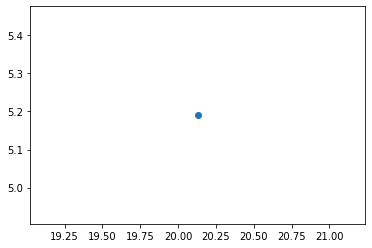

In [7]:
results, _ = calculate_best_cycle(input_values, input_ranges)
results_R134a = results[results['refrigerant'] == 'R134a']
ax = plt.subplot()
for sh in results_R134a['superheating']:
    r = results_R134a[results_R134a['superheating'] == sh]
    ax.plot(r['subcooling'], r['cop'], 'o')
plt.show()

In [13]:
# Superheating e Subcooling
 
# Calcula proximo k

def calculate_next(opt_input_values, delta, alpha):
    
    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    
    if opt_input_values['superheating'] <= opt_input_values['threshold_superheating']:
        current_superheating = opt_input_values['superheating']
        opt_input_values['superheating'] += delta
        cycle_oldsub_cursup = calculate_cycle(opt_input_values)
        opt_input_values['superheating'] = current_superheating
        gradient_sup = (cycle_oldsub_cursup['cop'] - cycle_oldsub_oldsup['cop']) / delta
        opt_input_values['superheating'] = current_superheating + alpha*gradient_sup
        
    if opt_input_values['subcooling'] <= opt_input_values['threshold_subcooling']:
        current_subcooling = opt_input_values['subcooling']
        opt_input_values['subcooling'] += delta
        cycle_cursub_oldsup = calculate_cycle(opt_input_values)
        gradient_sub = (cycle_cursub_oldsup['cop'] - cycle_oldsub_oldsup['cop']) / delta
        opt_input_values['subcooling'] = current_subcooling + alpha*gradient_sub

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'superheating': 5,
    'threshold_superheating': 10,
    'subcooling': 5,
    'threshold_subcooling': 10,
    'refrigerant': 'R134a'
}

opt_input_values['cop_carnot'] = opt_input_values['t_internal_env'] \
/ (opt_input_values['t_external_env'] - opt_input_values['t_internal_env'])
    
k = 0
while k < 100:
    next_pass = calculate_next(opt_input_values, 10**(-5), 1)
    k += 1
    print_cycle = calculate_cycle(opt_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)

##############################
Subcooling:  5.60893461730771
Superheating:  5.002375236007879
COP:  4.557934269584691
##############################
##############################
Subcooling:  6.148005025086718
Superheating:  5.004598801961464
COP:  4.581965419072754
##############################
##############################
Subcooling:  6.62921478139566
Superheating:  5.006688460629789
COP:  4.603372323634684
##############################
##############################
Subcooling:  7.061909604833545
Superheating:  5.0086588446635005
COP:  4.6225853926856955
##############################
##############################
Subcooling:  7.453490641496359
Superheating:  5.010522190407869
COP:  4.639944177654515
##############################
##############################
Subcooling:  7.809904575062916
Superheating:  5.01228885722071
COP:  4.655720575697972
##############################
##############################
Subcooling:  8.13598112002822
Superheating:  5.013967655299041
COP:  4

In [9]:
# Superheating
 
# Calcula proximo k

def calculate_next_superheating(opt_input_values, delta, alpha):
    current_superheating = opt_input_values['superheating']
    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    opt_input_values['superheating'] += delta
    cycle_oldsub_cursup = calculate_cycle(opt_input_values)

    gradient_sup = (cycle_oldsub_cursup['cop'] - cycle_oldsub_oldsup['cop']) / delta
    
    opt_input_values['superheating'] = current_superheating + alpha*gradient_sup

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'superheating': 5,
    'subcooling': 10,
    'refrigerant': 'R134a'
}

opt_input_values['cop_carnot'] = opt_input_values['t_internal_env'] \
/ (opt_input_values['t_external_env'] - opt_input_values['t_internal_env'])
    
k = 0
while k < 1000:
    next_pass = calculate_next_superheating(opt_input_values, 10**(-5), 10)
    k += 1
    print_cycle = calculate_cycle(opt_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)

##############################
Subcooling:  10
Superheating:  5.011388911147492
COP:  4.752171374776289
##############################
##############################
Subcooling:  10
Superheating:  5.0227913359296394
COP:  4.752184384184952
##############################
##############################
Subcooling:  10
Superheating:  5.034207485732907
COP:  4.752197424841249
##############################
##############################
Subcooling:  10
Superheating:  5.04563730637841
COP:  4.752210496732926
##############################
##############################
Subcooling:  10
Superheating:  5.057080881354921
COP:  4.752223600005197
##############################
##############################
Subcooling:  10
Superheating:  5.068538095199244
COP:  4.752236734575481
##############################
##############################
Subcooling:  10
Superheating:  5.08000897100402
COP:  4.75224990051972
##############################
##############################
Subcooling:  10
Superheati

Subcooling:  10
Superheating:  5.781404853711365
COP:  4.753084551993002
##############################
##############################
Subcooling:  10
Superheating:  5.793716533387112
COP:  4.753099718531376
##############################
##############################
Subcooling:  10
Superheating:  5.806042605994151
COP:  4.753114920471804
##############################
##############################
Subcooling:  10
Superheating:  5.818382909884008
COP:  4.753130157668479
##############################
##############################
Subcooling:  10
Superheating:  5.830737592494302
COP:  4.753145430357294
##############################
##############################
Subcooling:  10
Superheating:  5.843106594317078
COP:  4.753160738518574
##############################
##############################
Subcooling:  10
Superheating:  5.855490021933747
COP:  4.753176082338244
##############################
##############################
Subcooling:  10
Superheating:  5.867887851363491
COP:  

##############################
Subcooling:  10
Superheating:  6.678391569726045
COP:  4.7542352332873845
##############################
##############################
Subcooling:  10
Superheating:  6.691731070785352
COP:  4.7542530375005505
##############################
##############################
Subcooling:  10
Superheating:  6.705085626468872
COP:  4.754270881897972
##############################
##############################
Subcooling:  10
Superheating:  6.718455221677573
COP:  4.754288766517947
##############################
##############################
Subcooling:  10
Superheating:  6.731839840424243
COP:  4.754306691397498
##############################
##############################
Subcooling:  10
Superheating:  6.745239507577878
COP:  4.754324656628341
##############################
##############################
Subcooling:  10
Superheating:  6.758654308403607
COP:  4.754342662383632
##############################
##############################
Subcooling:  10
Superh

##############################
Subcooling:  10
Superheating:  7.649007182498053
COP:  4.755582503511912
##############################
##############################
Subcooling:  10
Superheating:  7.663422849380481
COP:  4.755603295881698
##############################
##############################
Subcooling:  10
Superheating:  7.677854111787781
COP:  4.755624133423818
##############################
##############################
Subcooling:  10
Superheating:  7.692301214857196
COP:  4.755645016555176
##############################
##############################
Subcooling:  10
Superheating:  7.70676398184122
COP:  4.755665945083151
##############################
##############################
Subcooling:  10
Superheating:  7.721242473135987
COP:  4.755686919157898
##############################
##############################
Subcooling:  10
Superheating:  7.735736734038596
COP:  4.755707938908056
##############################
##############################
Subcooling:  10
Superheat

##############################
Subcooling:  10
Superheating:  8.588233929541218
COP:  4.756984020323332
##############################
##############################
Subcooling:  10
Superheating:  8.603656955064594
COP:  4.757007819881534
##############################
##############################
Subcooling:  10
Superheating:  8.619096263562938
COP:  4.757031669700072
##############################
##############################
Subcooling:  10
Superheating:  8.634551853259893
COP:  4.757055569842447
##############################
##############################
Subcooling:  10
Superheating:  8.65002375257717
COP:  4.757079520419131
##############################
##############################
Subcooling:  10
Superheating:  8.66551195973841
COP:  4.757103521493826
##############################
##############################
Subcooling:  10
Superheating:  8.681016495171718
COP:  4.75712757316472
##############################
##############################
Subcooling:  10
Superheatin

##############################
Subcooling:  10
Superheating:  9.657966857557483
COP:  4.758693544418126
##############################
##############################
Subcooling:  10
Superheating:  9.67449880403592
COP:  4.758720888932675
##############################
##############################
Subcooling:  10
Superheating:  9.691047627680689
COP:  4.758748289216943
##############################
##############################
Subcooling:  10
Superheating:  9.707613289411938
COP:  4.758775745275868
##############################
##############################
Subcooling:  10
Superheating:  9.724195846961265
COP:  4.758803257275007
##############################
##############################
Subcooling:  10
Superheating:  9.740795191082725
COP:  4.758830825102825
##############################
##############################
Subcooling:  10
Superheating:  9.757411419475943
COP:  4.75885844899122
##############################
##############################
Subcooling:  10
Superheati

COP:  4.761095992420381
##############################
##############################
Subcooling:  10
Superheating:  11.070147242631663
COP:  4.761128118305664
##############################
##############################
Subcooling:  10
Superheating:  11.088084056443677
COP:  4.7611603067734425
##############################
##############################
Subcooling:  10
Superheating:  11.106038247466472
COP:  4.761192557721155
##############################
##############################
Subcooling:  10
Superheating:  11.124009879648895
COP:  4.761224871336604
##############################
##############################
Subcooling:  10
Superheating:  11.141998931674664
COP:  4.761257247654191
##############################
##############################
Subcooling:  10
Superheating:  11.160005464828089
COP:  4.761289686857339
##############################
##############################
Subcooling:  10
Superheating:  11.178029443582034
COP:  4.761322188955018
#######################

COP:  4.763945386649373
##############################
##############################
Subcooling:  10
Superheating:  12.599412124470462
COP:  4.763982920072266
##############################
##############################
Subcooling:  10
Superheating:  12.618799132025345
COP:  4.764020522994107
##############################
##############################
Subcooling:  10
Superheating:  12.63820404436899
COP:  4.764058195448424
##############################
##############################
Subcooling:  10
Superheating:  12.65762688281768
COP:  4.764095937551587
##############################
##############################
Subcooling:  10
Superheating:  12.677067681122196
COP:  4.7641337494443885
##############################
##############################
Subcooling:  10
Superheating:  12.696526434841644
COP:  4.764171631193356
##############################
##############################
Subcooling:  10
Superheating:  12.716003153745987
COP:  4.7642095828927635
########################

Superheating:  14.311843355064298
COP:  4.767436064643269
##############################
##############################
Subcooling:  10
Superheating:  14.332772894943275
COP:  4.767479888446721
##############################
##############################
Subcooling:  10
Superheating:  14.35372078103569
COP:  4.767523789106192
##############################
##############################
Subcooling:  10
Superheating:  14.374687069296783
COP:  4.767567766815269
##############################
##############################
Subcooling:  10
Superheating:  14.395671697554064
COP:  4.767611821519751
##############################
##############################
Subcooling:  10
Superheating:  14.416674680018389
COP:  4.76765595332558
##############################
##############################
Subcooling:  10
Superheating:  14.437696049552358
COP:  4.767700162378081
##############################
##############################
Subcooling:  10
Superheating:  14.458735762635229
COP:  4.76774444

Subcooling:  10
Superheating:  15.799236094705122
COP:  4.770644658565681
##############################
##############################
Subcooling:  10
Superheating:  15.821440679542604
COP:  4.77069398371486
##############################
##############################
Subcooling:  10
Superheating:  15.843663893034261
COP:  4.770743391586106
##############################
##############################
Subcooling:  10
Superheating:  15.865905754720018
COP:  4.770792882299119
##############################
##############################
Subcooling:  10
Superheating:  15.88816624417177
COP:  4.770842455884638
##############################
##############################
Subcooling:  10
Superheating:  15.910445346290487
COP:  4.770892112385168
##############################
##############################
Subcooling:  10
Superheating:  15.932742982028287
COP:  4.770941851700177
##############################
##############################
Subcooling:  10
Superheating:  15.955059323691785


##############################
Subcooling:  10
Superheating:  17.920267577598565
COP:  4.775538888628898
##############################
##############################
Subcooling:  10
Superheating:  17.944194284436605
COP:  4.775596159915899
##############################
##############################
Subcooling:  10
Superheating:  17.96813982154532
COP:  4.775653521329482
##############################
##############################
Subcooling:  10
Superheating:  17.992104165832075
COP:  4.775710972888894
##############################
##############################
Subcooling:  10
Superheating:  18.01608736437032
COP:  4.7757685147814986
##############################
##############################
Subcooling:  10
Superheating:  18.040089379856568
COP:  4.775826146992299
##############################
##############################
Subcooling:  10
Superheating:  18.064110232718917
COP:  4.775883869644912
##############################
##############################
Subcooling:  10
Su

COP:  4.781260480165548
##############################
##############################
Subcooling:  10
Superheating:  20.251775984381766
COP:  4.781326455573677
##############################
##############################
Subcooling:  10
Superheating:  20.277475838182397
COP:  4.781392528100929
##############################
##############################
Subcooling:  10
Superheating:  20.3031945595572
COP:  4.781458697713659
##############################
##############################
Subcooling:  10
Superheating:  20.32893219291509
COP:  4.781524964597479
##############################
##############################
Subcooling:  10
Superheating:  20.35468875069057
COP:  4.781591328855993
##############################
##############################
Subcooling:  10
Superheating:  20.380464152059403
COP:  4.781657790352112
##############################
##############################
Subcooling:  10
Superheating:  20.406258443206866
COP:  4.781724349276046
############################

##############################
Subcooling:  10
Superheating:  22.042381762699677
COP:  4.7860441796687105
##############################
##############################
Subcooling:  10
Superheating:  22.069365225275135
COP:  4.786117015895405
##############################
##############################
Subcooling:  10
Superheating:  22.096367594504613
COP:  4.786189954062321
##############################
##############################
Subcooling:  10
Superheating:  22.12338886505904
COP:  4.786262994223595
##############################
##############################
Subcooling:  10
Superheating:  22.15042895256147
COP:  4.786336136219351
##############################
##############################
Subcooling:  10
Superheating:  22.17748782148476
COP:  4.786409380021199
##############################
##############################
Subcooling:  10
Superheating:  22.204565577522146
COP:  4.786482725983236
##############################
##############################
Subcooling:  10
Sup

COP:  4.793179160071027
##############################


In [10]:
# Subcooling
 
# Calcula proximo k

def calculate_next_subcooling(opt_input_values, delta, alpha):
    current_subcooling = opt_input_values['subcooling']
    cycle_oldsub_oldsup = calculate_cycle(opt_input_values)
    opt_input_values['subcooling'] += delta
    cycle_cursub_oldsup = calculate_cycle(opt_input_values)

    gradient_sup = (cycle_cursub_oldsup['cop'] - cycle_oldsub_oldsup['cop']) / delta
    
    opt_input_values['subcooling'] = current_subcooling + alpha*gradient_sup

# Variaveis de entrada para otimizacao
opt_input_values = {
    't_external_env': 35 + 273.15,
    't_internal_env': 18 + 273.15,
    'approach_condenser': 10,
    'approach_evaporator': 10,
    'q_evaporator': 9000 * 0.293071,
    'isentropic_efficiency': 0.7,
    'superheating': 5,
    'subcooling': 5,
    'refrigerant': 'R134a'
}

opt_input_values['cop_carnot'] = opt_input_values['t_internal_env'] \
/ (opt_input_values['t_external_env'] - opt_input_values['t_internal_env'])
    
k = 0
while k < 100:
    next_pass = calculate_next_subcooling(opt_input_values, 10**(-8), 10)
    k += 1
    print_cycle = calculate_cycle(opt_input_values)
    print('#'*30)
    print('Subcooling: ', print_cycle['cycle_inputs']['subcooling'])
    print('Superheating: ', print_cycle['cycle_inputs']['superheating'])
    print('COP: ', print_cycle['cop'])
    print('#'*30)

##############################
Subcooling:  5.447344383758264
Superheating:  5
COP:  4.55071636335769
##############################
##############################
Subcooling:  5.8938494389099105
Superheating:  5
COP:  4.570634509409855
##############################
##############################
Subcooling:  6.339527599952817
Superheating:  5
COP:  4.590479386475317
##############################
##############################
Subcooling:  6.784400183169055
Superheating:  5
COP:  4.610252654289838
##############################
##############################
Subcooling:  7.228476958521242
Superheating:  5
COP:  4.629955434899296
##############################
##############################
Subcooling:  7.671765031436735
Superheating:  5
COP:  4.649588711149374
##############################
##############################
Subcooling:  8.114282165483928
Superheating:  5
COP:  4.669153917045294
##############################
##############################
Subcooling:  8.556039018803858


##############################
Subcooling:  35.20436345479993
Superheating:  5
COP:  5.8157089051020066
##############################
##############################
Subcooling:  35.612497425863694
Superheating:  5
COP:  5.832358563689962
##############################
##############################
Subcooling:  36.02025569745592
Superheating:  5
COP:  5.848977589345719
##############################
##############################
Subcooling:  36.42764004593346
Superheating:  5
COP:  5.865566201337958
##############################
##############################
Subcooling:  36.83465224765314
Superheating:  5
COP:  5.88212461660915
##############################
##############################
Subcooling:  37.241296743507064
Superheating:  5
COP:  5.898653158077807
##############################
##############################
Subcooling:  37.64757619803049
Superheating:  5
COP:  5.915152073938571
##############################
##############################
Subcooling:  38.0534906112234